# Case Study  - Titanic Survival

# Feature Extraction

Here we will talk about an important piece of machine learning: the extraction of
quantitative features from data.  By the end of this section you will

- Know how features are extracted from real-world data.
- See an example of extracting numerical features from textual data

In addition, we will go over several basic tools within scikit-learn which can be used to accomplish the above tasks.

## What Are Features?

### Numerical Features

Recall that data in scikit-learn is expected to be in two-dimensional arrays, of size
**n_samples** $\times$ **n_features**.

Previously, we looked at the iris dataset, which has 150 samples and 4 features

In [1]:
from sklearn.datasets import load_iris

iris = load_iris()
print(iris.data.shape)

(150, 4)


These features are:

- sepal length in cm
- sepal width in cm
- petal length in cm
- petal width in cm

Numerical features such as these are pretty straightforward: each sample contains a list
of floating-point numbers corresponding to the features

### Categorical Features

What if you have categorical features?  For example, imagine there is data on the color of each
iris:

    color in [red, blue, purple]

You might be tempted to assign numbers to these features, i.e. *red=1, blue=2, purple=3*
but in general **this is a bad idea**.  Estimators tend to operate under the assumption that
numerical features lie on some continuous scale, so, for example, 1 and 2 are more alike
than 1 and 3, and this is often not the case for categorical features.

In fact, the example above is a subcategory of "categorical" features, namely, "nominal" features. Nominal features don't imply an order, whereas "ordinal" features are categorical features that do imply an order. An example of ordinal features would be T-shirt sizes, e.g., XL > L > M > S. 

One work-around for parsing nominal features into a format that prevents the classification algorithm from asserting an order is the so-called one-hot encoding representation. Here, we give each category its own dimension.  

The enriched iris feature set would hence be in this case:

- sepal length in cm
- sepal width in cm
- petal length in cm
- petal width in cm
- color=purple (1.0 or 0.0)
- color=blue (1.0 or 0.0)
- color=red (1.0 or 0.0)

Note that using many of these categorical features may result in data which is better
represented as a **sparse matrix**, as we'll see with the text classification example
below.

#### Using the DictVectorizer to encode categorical features

When the source data is encoded has a list of dicts where the values are either strings names for categories or numerical values, you can use the `DictVectorizer` class to compute the boolean expansion of the categorical features while leaving the numerical features unimpacted:

In [2]:
measurements = [
    {'city': 'Dubai', 'temperature': 33.},
    {'city': 'London', 'temperature': 12.},
    {'city': 'San Francisco', 'temperature': 18.},
]

In [3]:
from sklearn.feature_extraction import DictVectorizer

vec = DictVectorizer()
vec

DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        sparse=True)

In [4]:
vec.fit_transform(measurements).toarray()

array([[ 1.,  0.,  0., 33.],
       [ 0.,  1.,  0., 12.],
       [ 0.,  0.,  1., 18.]])

In [5]:
vec.get_feature_names()

['city=Dubai', 'city=London', 'city=San Francisco', 'temperature']

### Derived Features

Another common feature type are **derived features**, where some pre-processing step is
applied to the data to generate features that are somehow more informative.  Derived
features may be based in **feature extraction** and **dimensionality reduction** (such as PCA or manifold learning),
may be linear or nonlinear combinations of features (such as in polynomial regression),
or may be some more sophisticated transform of the features.

### Combining Numerical and Categorical Features

As an example of how to work with both categorical and numerical data, we will perform survival predicition for the passengers of the HMS Titanic.

We will use a version of the Titanic (titanic3.xls) from [here](http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3.xls). We converted the .xls to .csv for easier manipulation but left the data is otherwise unchanged.

We need to read in all the lines from the (titanic3.csv) file, set aside the keys from the first line, and find our labels (who survived or died) and data (attributes of that person). Let's look at the keys and some corresponding example lines.

In [6]:
import os
import pandas as pd

titanic = pd.read_csv(os.path.join('datasets', 'titanic3.csv'))
print(titanic.columns)

Index(['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest'],
      dtype='object')


Here is a broad description of the keys and what they mean:

```
pclass          Passenger Class
                (1 = 1st; 2 = 2nd; 3 = 3rd)
survival        Survival
                (0 = No; 1 = Yes)
name            Name
sex             Sex
age             Age
sibsp           Number of Siblings/Spouses Aboard
parch           Number of Parents/Children Aboard
ticket          Ticket Number
fare            Passenger Fare
cabin           Cabin
embarked        Port of Embarkation
                (C = Cherbourg; Q = Queenstown; S = Southampton)
boat            Lifeboat
body            Body Identification Number
home.dest       Home/Destination
```

In general, it looks like `name`, `sex`, `cabin`, `embarked`, `boat`, `body`, and `homedest` may be candidates for categorical features, while the rest appear to be numerical features. We can also look at the first couple of rows in the dataset to get a better understanding:

In [7]:
titanic.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


We clearly want to discard the "boat" and "body" columns for any classification into survived vs not survived as they already contain this information. The name is unique to each person (probably) and also non-informative. For a first try, we will use "pclass", "sibsp", "parch", "fare" and "embarked" as our features:

In [8]:
labels = titanic.survived.values
features = titanic[['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']]

In [9]:
features.head()

,pclass,sex,age,sibsp,parch,fare,embarked
0,1,female,29.0000,0,0,211.3375,S
1,1,male,0.9167,1,2,151.5500,S
2,1,female,2.0000,1,2,151.5500,S
3,1,male,30.0000,1,2,151.5500,S
4,1,female,25.0000,1,2,151.5500,S


The data now contains only useful features, but they are not in a format that the machine learning algorithms can understand. We need to transform the strings "male" and "female" into binary variables that indicate the gender, and similarly for "embarked".
We can do that using the pandas ``get_dummies`` function:

In [10]:
pd.get_dummies(features).head()

,pclass,age,sibsp,parch,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
0,1,29.0000,0,0,211.3375,1,0,0,0,1
1,1,0.9167,1,2,151.5500,0,1,0,0,1
2,1,2.0000,1,2,151.5500,1,0,0,0,1
3,1,30.0000,1,2,151.5500,0,1,0,0,1
4,1,25.0000,1,2,151.5500,1,0,0,0,1


This transformation successfully encoded the string columns. However, one might argue that the class is also a categorical variable. We can explicitly list the columns to encode using the ``columns`` parameter, and include ``pclass``:

In [11]:
features_dummies = pd.get_dummies(features, columns=['pclass', 'sex', 'embarked'])
features_dummies.head(n=16)

,age,sibsp,parch,fare,pclass_1,pclass_2,pclass_3,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
0,29.0000,0,0,211.3375,1,0,0,1,0,0,0,1
1,0.9167,1,2,151.5500,1,0,0,0,1,0,0,1
2,2.0000,1,2,151.5500,1,0,0,1,0,0,0,1
3,30.0000,1,2,151.5500,1,0,0,0,1,0,0,1
4,25.0000,1,2,151.5500,1,0,0,1,0,0,0,1
5,48.0000,0,0,26.5500,1,0,0,0,1,0,0,1
6,63.0000,1,0,77.9583,1,0,0,1,0,0,0,1
7,39.0000,0,0,0.0000,1,0,0,0,1,0,0,1
8,53.0000,2,0,51.4792,1,0,0,1,0,0,0,1
9,71.0000,0,0,49.5042,1,0,0,0,1,1,0,0


In [12]:
data = features_dummies.values

In [13]:
import numpy as np
np.isnan(data).any()

True

In [14]:
print(data.shape) 

(1309, 12)


With all of the hard data loading work out of the way, evaluating a classifier on this data becomes straightforward. Setting up the simplest possible model, we want to see what the simplest score can be with `DummyClassifier`.

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer


train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, random_state=0)

imp = Imputer()
imp.fit(train_data)
train_data_finite = imp.transform(train_data)
test_data_finite = imp.transform(test_data)

C:\Users\afunn\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [16]:
np.isnan(train_data_finite).any()

False

In [17]:
from sklearn.dummy import DummyClassifier

clf = DummyClassifier('most_frequent')
clf.fit(train_data_finite, train_labels)
print("Prediction accuracy: %f"
      % clf.score(test_data_finite, test_labels))

Prediction accuracy: 0.634146


<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>
      Try executing the above classification, using LogisticRegression and RandomForestClassifier instead of DummyClassifier
      </li>
      <li>
      Does selecting a different subset of features help?
      </li>
    </ul>
</div>

In [18]:
#BMC code

In [19]:
# re-label the data as X,y and ensure the imputer transforms the nan values to real numbers
X_train, X_test, y_train, y_test = imp.transform(train_data), imp.transform(test_data), train_labels, test_labels 

In [20]:
# Test with linear regression

from sklearn.linear_model import LogisticRegression #import the 'Estimator', i.e. the classifier

classifierLR = LogisticRegression() # initialise the classifier

classifierLR.fit(X_train, y_train) # fit the classifier

#prediction = classifierLR.predict(X_test)

print("Test score ", classifierLR.score(X_test, y_test))
print("Train score ", classifierLR.score(X_train, y_train))

Test score  0.7926829268292683
Train score  0.7940876656472987


C:\Users\afunn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [21]:
# Test with random forest classifier

from sklearn.ensemble import RandomForestClassifier #import the 'Estimator', i.e. the classifier

classifierRF = RandomForestClassifier(n_estimators=10) #initialise the classifier

classifierRF.fit(X_train,y_train) #fit the classifier

print("Test score ", classifierRF.score(X_test,y_test))
print("Train score ", classifierRF.score(X_train,y_train))


Test score  0.7530487804878049
Train score  0.9643221202854231


## Solutions

In [22]:
# %load solutions/10_titanic.py
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression().fit(train_data_finite, train_labels)
print("logistic regression score: %f" % lr.score(test_data_finite, test_labels))

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=500, random_state=0).fit(train_data_finite, train_labels)
print("random forest score: %f" % rf.score(test_data_finite, test_labels))

features_dummies_sub = pd.get_dummies(features[['pclass', 'sex', 'age', 'sibsp', 'fare']])
data_sub = features_dummies_sub.values

train_data_sub, test_data_sub, train_labels, test_labels = train_test_split(data_sub, labels, random_state=0)

imp = Imputer()
imp.fit(train_data_sub)
train_data_finite_sub = imp.transform(train_data_sub)
test_data_finite_sub = imp.transform(test_data_sub)
                                         
lr = LogisticRegression().fit(train_data_finite_sub, train_labels)
print("logistic regression score w/o embark, parch: %f" % lr.score(test_data_finite_sub, test_labels))
rf = RandomForestClassifier(n_estimators=500, random_state=0).fit(train_data_finite_sub, train_labels)
print("random forest score w/o embark, parch: %f" % rf.score(test_data_finite_sub, test_labels))


logistic regression score: 0.792683


C:\Users\afunn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


random forest score: 0.777439
logistic regression score w/o embark, parch: 0.789634


C:\Users\afunn\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\afunn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


random forest score w/o embark, parch: 0.801829


## BMC extension to test the use of 'groupby functionality ' on the titanic data

In [24]:
titanic.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [27]:
titanic.groupby(['pclass','sex','survived']).size()

pclass  sex     survived
1       female  0             5
                1           139
        male    0           118
                1            61
2       female  0            12
                1            94
        male    0           146
                1            25
3       female  0           110
                1           106
        male    0           418
                1            75
dtype: int64

In [95]:
titanic.groupby(['pclass','sex']).size()

pclass  sex   
1       female    144
        male      179
2       female    106
        male      171
3       female    216
        male      493
dtype: int64

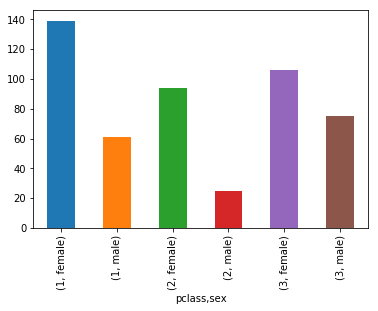

In [39]:
titanic[titanic.survived==1].groupby(['pclass','sex']).size().plot(kind='bar')

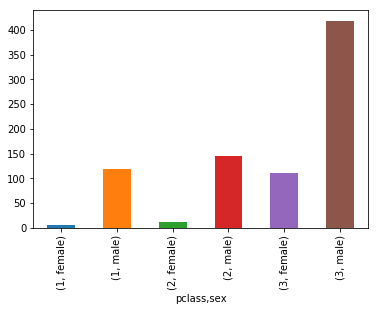

In [40]:
titanic[titanic.survived==0].groupby(['pclass','sex']).size().plot(kind='bar')

In [115]:
#Plots as percentages of each class
# d = titanic.drop('age',axis=1)
g = titanic.groupby(['pclass','sex']).sum().drop(['age','sibsp','parch','fare','body'], axis=1)
g

survived
pclass sex             
1      female       139
       male          61
2      female        94
       male          25
3      female       106
       male          75

In [116]:
q = titanic.groupby(['pclass','sex']).count().drop(['name','age','sibsp','parch','ticket','fare','cabin', 'embarked', 'boat', 'body', 'home.dest'], axis=1)

In [117]:
#g2 = g / g.groupby(level=1).sum()
g2 = g / q
g2

survived
pclass sex             
1      female  0.965278
       male    0.340782
2      female  0.886792
       male    0.146199
3      female  0.490741
       male    0.152130

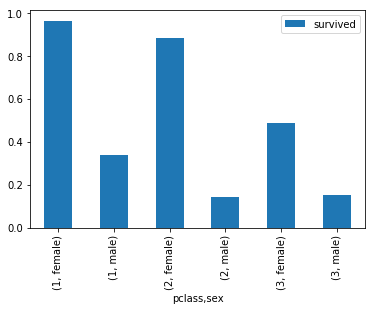

In [119]:
#Plot of survivors of the titanic in percentage

g2.plot(kind='bar')